# Bike Sharing Rebalancing Problem

The following implementation is derivated from the following paper: https://www.sciencedirect.com/science/article/abs/pii/S0305048313001187


## Introduction

| Variable Name  | Description |
| ------------- | ------------- |
| <i>V</i>   | Set of vertices |
| <i>A</i>   | Set of arcs  |
| <i>n</i>   | Number of stations |
| <i>m</i>   |  Number of vehicles  |
| <i>Q</i>   | Vehicle capacity |
| <i>q<sub>i</sub></i>  |  Demand at vertex i  |
| <i>c<sub>ij</sub></i>  |  Cost of arc (i,j)  |

In [4]:
#Importing cplex API
import sys
try:
    import docplex.cp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex# Bike Sharing Rebalancing Problem
        
#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

In [17]:
n = 8                                          # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = 10                                           # vehicles capacity
V = [0] + [i for i in range(1, n+1)]           # stations(including deposit)
A = [(i, j) for i in V for j in V]               # edges
q = {i: rand.randint(-Q, Q) for i in V}           # demand along edges
q[0] = 0


In [32]:
# generazione casuale coordinate
coord = rand.rand(len(V), 2) * 500

c = {(i, j): 
        np.hypot(coord[i][0]-coord[j][0], coord[i][1]-coord[j][1]) 
             for i, j in A}       

coord

array([[475.11975177, 399.39979635],
       [472.33542007, 294.46205572],
       [440.81843363, 320.52567617],
       [127.24516357,  77.68453271],
       [240.29246908, 439.12970542],
       [ 21.96066387, 285.66461455],
       [ 70.00719535, 319.14896146],
       [395.7953751 , 328.77980924],
       [283.53086238, 315.69052494]])

(-0.6972905300302905,
 497.77770616641516,
 59.61227407615677,
 457.20196405396285)

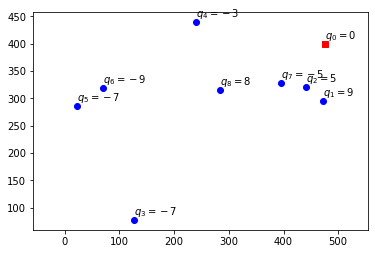

In [84]:
for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')

for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0], coord[i][1]+10))

plt.plot(coord[0][0], coord[0][1], c='r', marker='s') #marker=(5, 1)
plt.axis('equal')

294.4620557177349